<a href="https://colab.research.google.com/github/decci027/datascience_a2/blob/main/Unit5Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm

from scipy.interpolate import PchipInterpolator

In [2]:
#load the data into a pandas dataframe, and print it
url_iris = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/iris.csv'
#I could have put the url string directly into pd.read_csv()
iris = pd.read_csv(url_iris)


In [3]:
print(iris)

     sepal_length  sepal_width  petal_length  petal_width    species
0             5.1          3.5           1.4          0.2     setosa
1             4.9          3.0           1.4          0.2     setosa
2             4.7          3.2           1.3          0.2     setosa
3             4.6          3.1           1.5          0.2     setosa
4             5.0          3.6           1.4          0.2     setosa
..            ...          ...           ...          ...        ...
145           6.7          3.0           5.2          2.3  virginica
146           6.3          2.5           5.0          1.9  virginica
147           6.5          3.0           5.2          2.0  virginica
148           6.2          3.4           5.4          2.3  virginica
149           5.9          3.0           5.1          1.8  virginica

[150 rows x 5 columns]


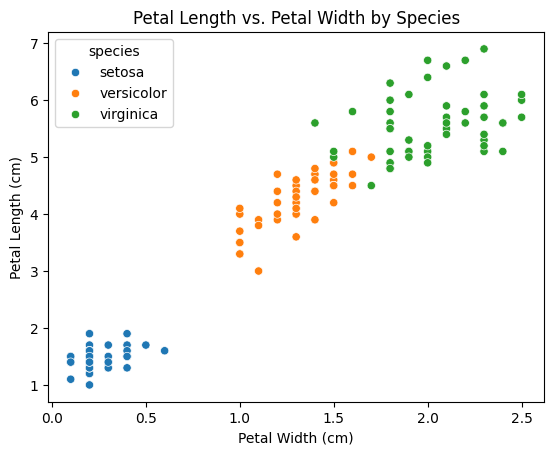

In [4]:
# @title Petal Length vs. Petal Width by Species

import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'iris' is your DataFrame
sns.scatterplot(x='petal_width', y='petal_length', hue='species', data=iris)
plt.xlabel('Petal Width (cm)')
plt.ylabel('Petal Length (cm)')
_ = plt.title('Petal Length vs. Petal Width by Species')

<Axes: xlabel='petal_width', ylabel='petal_length'>

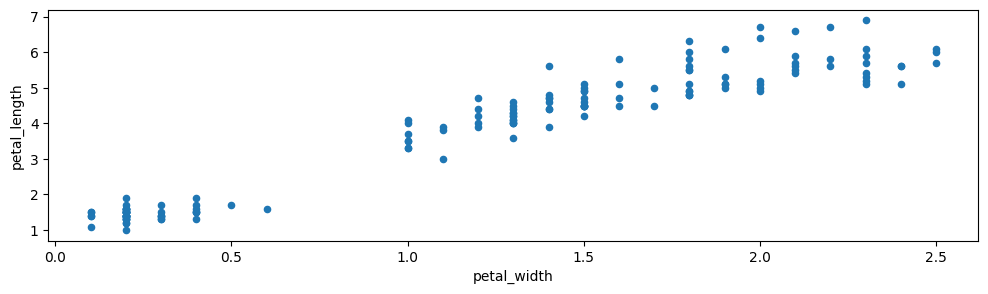

In [5]:
#scatter plot of temperature v. rented count of bikes
iris.plot(x="petal_width", y="petal_length", figsize=(12, 3), kind="scatter")


In the graph above, I noticed a gap between approximately 0.5 and 1.0. At first, I wasn’t sure what it meant, but I guessed it might represent data that was difficult to find or collect. When I asked Mr. A about it, he explained using the recommended plots, which showed the three different petal species. It became clear that there was no data for any of the species in the range between 0.5 and 1.0.

In [6]:
#li stands for linear iris
with pm.Model() as model_li:

    #priors for the linear part of our model
    α = pm.Normal("α", mu=0, sigma=100)
    β = pm.Normal("β", mu=0, sigma=10)

    #this is the linear part of our model
    μ = pm.Deterministic("μ", α + β * iris.petal_width)

    #prior for the standard deviation of our likelihood
    #Cauchy is a T dist with nu = 1
    σ = pm.HalfCauchy("σ", 10)

    #likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed= iris.petal_length)

    #inference data object
    idata_li = pm.sample()


Output()

Output()

array([<Axes: title={'center': 'α'}>, <Axes: title={'center': 'β'}>,
       <Axes: title={'center': 'σ'}>], dtype=object)

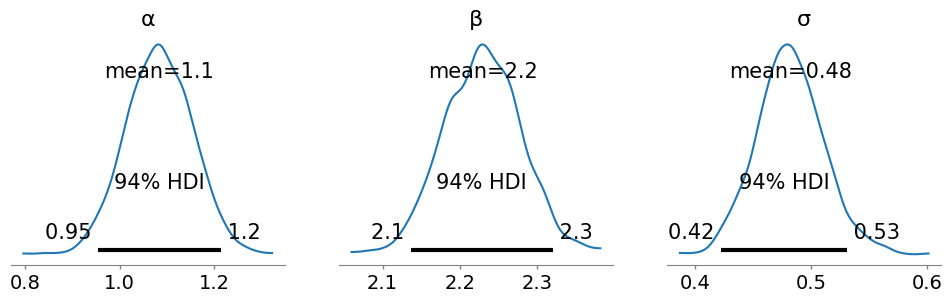

In [7]:

#plot of the posteriors for all the components of my line
#'~μ' means plot all variables except μ
az.plot_posterior(idata_li, var_names=["~μ"], figsize=(12, 3))


Text(0, 0.5, 'petal length')

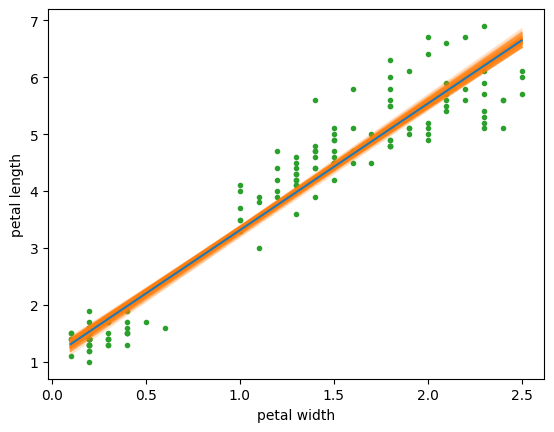

In [8]:

#grabs 100 posterior samples
posterior = az.extract(idata_li, num_samples=100)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(iris.petal_width.min(), iris.petal_width.max(), 50),
    dims="plot_id"
    )

# this creates the expected line, the path we predict temperature and
#rented bike count deviates from
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

#These are a 50 lines that our model came up with
lines = posterior["α"] + posterior["β"] * x_plot

#set up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, mean_line, c="C0", label="mean line")

#plot the raw data
ax.plot(iris.petal_width, iris.petal_length, "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("petal width")
ax.set_ylabel("petal length")


The graph shows how petal width and petal length are connected. The dark orange line represents the model's best guess for how the data should line up if the relationship is truly a straight line. The lighter orange lines show other possible fits, accounting for the model’s uncertainty. Since the lines stick pretty close to the data points, it means the model does a solid job of capturing the trend. There’s a small gap in the data between 0.5 and 1.0 petal width, but the model still predicts smoothly through that gap. Overall, the model fits the data well and highlights a clear relationship between petal width and length.

In [9]:
# posterior predictive check
pm.sample_posterior_predictive(idata_li, model=model_li,  extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'petal length')

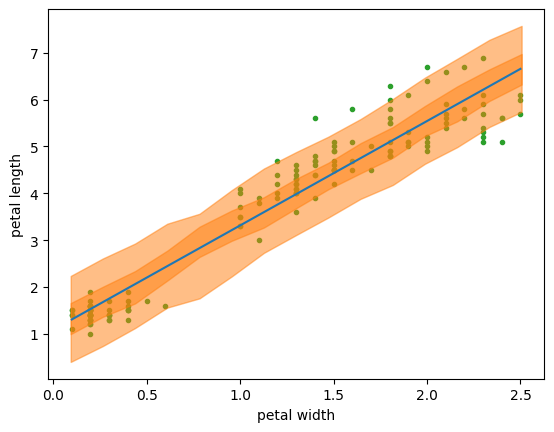

In [10]:

#plots the posterior predictive distribution

#grabs the expected line, or line of best fit formula
mean_line = idata_li.posterior["μ"].mean(("chain", "draw"))

#creates some x values to run through our line formula
petal_width = np.random.normal(iris.petal_width.values, 0.01)
idx = np.argsort(petal_width)
x = np.linspace(petal_width.min(), petal_width.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_li.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(petal_width[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(iris.petal_width, iris.petal_length, "C2.", zorder=-3)
ax.plot(iris.petal_width[idx], mean_line[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("petal width")
ax.set_ylabel("petal length")


 The graph shows a positive linear relationship between petal width and petal length: as petal width increases, petal length also increases. The blue line represents the line of best fit, showing the model's prediction for this trend. The orange shaded areas capture the uncertainty in these predictions, with the green dots mostly falling within the intervals, especially the wider 94% HDI. The model mostly captures the pattern in the data, while still accounting for some variability in petal lengths at given petal widths.

<Axes: xlabel='y_pred'>

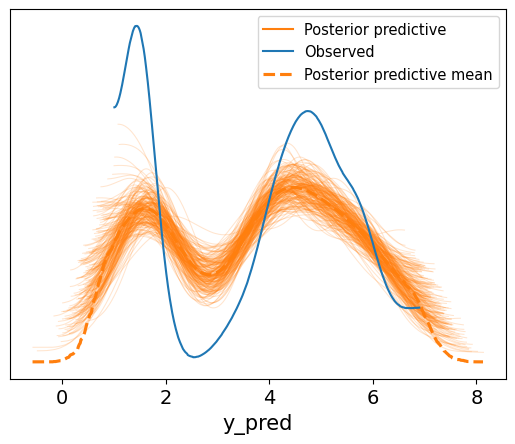

In [11]:
#posterior predictive check
az.plot_ppc(idata_li, num_pp_samples=200, colors=["C1", "C0", "C1"])

This graph shows that the model doesn’t really match the data well. The orange lines and the dashed line make a smooth prediction, but they don't align with the two modes of the blue line. Additionally, the model itself seems a too simple and overlooks the strange patterns in the data. While the predictions follow the overall trend, it doesn't really encapsulate the actual data, which shows the model might not fully grasp what it is trying to read.

In [12]:
import pymc as pm
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load the Iris dataset
from sklearn.datasets import load_iris
data = load_iris(as_frame=True)
iris = data.frame

# Add species index
le = LabelEncoder()
iris["species_idx"] = le.fit_transform(iris["target"])  # Encode species as 0, 1, 2
species = le.classes_

# Define coordinate system
iris_coords = {"species": species}

# PyMC Model
with pm.Model(coords=iris_coords) as h_model:
    # Hyper-priors
    α_μ = pm.Normal("α_μ", mu=iris["sepal length (cm)"].mean(), sigma=3)
    α_σ = pm.HalfNormal("α_σ", 5)
    β_μ = pm.Normal("β_μ", mu=0, sigma=3)
    β_σ = pm.HalfNormal("β_σ", 5)

    # Priors
    α = pm.Normal("α", mu=α_μ, sigma=α_σ, dims="species")
    β = pm.Normal("β", mu=β_μ, sigma=β_σ, dims="species")
    σ = pm.HalfNormal("σ", 3)

    # Likelihood
    # Linear relationship between petal length and petal width by species
    species_idx = iris["species_idx"].values
    y = pm.Normal(
        "y_pred",
        mu=α[species_idx] + β[species_idx] * iris["petal width (cm)"],
        sigma=σ,
        observed=iris["petal length (cm)"]
    )

    # Sampling
    idata_h_b = pm.sample(target_accept=0.99)


Output()

Output()

Text(0, 0.5, 'Petal Length (cm)')

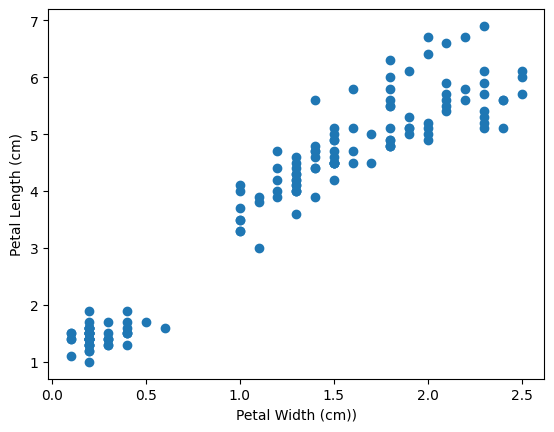

In [22]:
plt.scatter(iris["petal width (cm)"], iris['petal length (cm)'])

#label axes
plt.xlabel("Petal Width (cm))")
plt.ylabel("Petal Length (cm)")


Shown above is a scatter plot. I wanted to create this graph to show the relationship between petal width and petal length. As petal width increases (x-axis), petal length (y-axis) increases too, showing a clear upward trend. The data points form a few clusters, which probably means there are different groups or species in the mix. In additoin, the relationship looks pretty linear, so there’s a strong positive correlation here—basically, wider petals tend to come with longer petals.

Output()

Output()

Output()

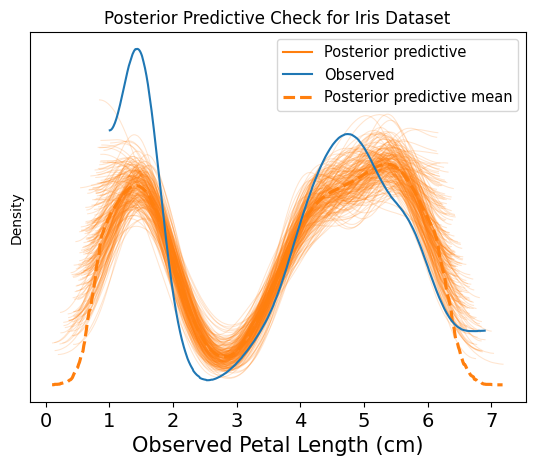

In [14]:
# PyMC Model
with pm.Model(coords=iris_coords) as h_model:
    # Hyper-priors
    α_μ = pm.Normal("α_μ", mu=iris["sepal length (cm)"].mean(), sigma=3)
    α_σ = pm.HalfNormal("α_σ", 5)
    β_μ = pm.Normal("β_μ", mu=0, sigma=3)
    β_σ = pm.HalfNormal("β_σ", 5)

    # Priors
    α = pm.Normal("α", mu=α_μ, sigma=α_σ, dims="species")
    β = pm.Normal("β", mu=β_μ, sigma=β_σ, dims="species")
    σ = pm.HalfNormal("σ", 5)

    # Likelihood
    # Linear relationship between petal length and petal width by species
    species_idx = iris["species_idx"].values
    y = pm.Normal(
        "y_pred",
        mu=α[species_idx] + β[species_idx] * iris["petal width (cm)"],
        sigma=σ,
        observed=iris["petal length (cm)"]
    )

    # Sampling
    idata_h_b = pm.sample(target_accept=0.99) #<-- here is the original inference data object

# Generate posterior predictive samples, notice we pass h_model
ppc = pm.sample_posterior_predictive(idata_h_b, model=h_model)

# Update idata_h_b with posterior predictive samples
idata_h_b.extend(ppc)

# Posterior Predictive Check
az.plot_ppc(
    idata_h_b,
    num_pp_samples=200,  # Number of posterior predictive samples to include in the plot
    colors=["C1", "C0", "C1"],  # Colors for visualizing observed vs predicted data
)
plt.title("Posterior Predictive Check for Iris Dataset")
plt.xlabel("Observed Petal Length (cm)")
plt.ylabel("Density")
plt.show()

The model does a much better job here because the orange lines almost line up with the shape of the blue line, which shows the overall average. This means the model can actually capture the patterns in petal length, like the two peaks around 1.5 cm and 5 cm. This graph is a big improvement over the earlier one because it shows not just the overall trend but also the variation in predictions with the thin orange lines. These lines let us see how consistent the model is with the real data and give us a sense of the model's uncertainty. All this detail makes it easier to tell how reliable and accurate the model really is.